In [1]:
# =========================================================
#  Step 1: Setup & Dataset Download
# =========================================================
!pip install tensorflow==2.15.0 --quiet

import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print("TensorFlow version:", tf.__version__)

# Download dataset from UCI directly
!wget -O realwaste.zip "https://archive.ics.uci.edu/static/public/908/realwaste.zip"
!unzip -q realwaste.zip -d realwaste_dataset

# Inspect folder structure
for root, dirs, files in os.walk("realwaste_dataset"):
    print(root, "->", len(files), "files")


ERROR: Could not find a version that satisfies the requirement tensorflow==2.15.0 (from versions: 2.16.0rc0, 2.16.1, 2.16.2, 2.17.0rc0, 2.17.0rc1, 2.17.0, 2.17.1, 2.18.0rc0, 2.18.0rc1, 2.18.0rc2, 2.18.0, 2.18.1, 2.19.0rc0, 2.19.0, 2.19.1, 2.20.0rc0, 2.20.0)
ERROR: No matching distribution found for tensorflow==2.15.0
TensorFlow version: 2.19.0
--2025-11-26 15:32:00--  https://archive.ics.uci.edu/static/public/908/realwaste.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘realwaste.zip’

realwaste.zip           [              <=>   ] 656.65M  17.2MB/s    in 11s     

2025-11-26 15:32:11 (60.0 MB/s) - ‘realwaste.zip’ saved [688545323]

realwaste_dataset -> 0 files
realwaste_dataset/realwaste-main -> 1 files
realwaste_dataset/realwaste-main/RealWaste -> 0 files
realwaste_dataset/realwaste-main/Real

In [2]:
# =========================================================
#  Step 2 & 3: Create 70–15–15 train/val/test split
# =========================================================
import tensorflow as tf

DATASET_PATH = "realwaste_dataset/realwaste-main/RealWaste"
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 16
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)

# Step 1: split 85% (train+val) and 15% (test)
train_val_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.15,   # 15% test
    subset="training",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)
test_ds = tf.keras.utils.image_dataset_from_directory(
    DATASET_PATH,
    validation_split=0.15,   # 15% test
    subset="validation",
    seed=123,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

# Step 2: further split train_val_ds → 70% train, 15% val (out of total)
train_size = 0.8235  # 70/85
val_size = 0.1765    # 15/85

train_batches = int(len(train_val_ds) * train_size)
train_ds = train_val_ds.take(train_batches)
val_ds = train_val_ds.skip(train_batches)

# Cache and prefetch
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)
test_ds = test_ds.cache().prefetch(AUTOTUNE)

# Save class names
class_names = train_val_ds.class_names
num_classes = len(class_names)
print("✅ Classes detected:", class_names)

print(f"Train batches: {len(train_ds)}")
print(f"Val batches:   {len(val_ds)}")
print(f"Test batches:  {len(test_ds)}")


Found 4752 files belonging to 9 classes.
Using 4040 files for training.
Found 4752 files belonging to 9 classes.
Using 712 files for validation.
✅ Classes detected: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']
Train batches: 208
Val batches:   45
Test batches:  45


In [3]:
# =========================================================
#  Step 4: Build ResNet-50 model
# =========================================================
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
)

# Freeze the pretrained convolutional base
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

optimizer = Adam(learning_rate=3e-4)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,114,569 (91.99 MB)

 Trainable params: 526,857 (2.01 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [4]:
# =========================================================
# Define useful callbacks
# =========================================================
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True,
    verbose=1
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

checkpoint = ModelCheckpoint(
    filepath='best_resnet50.keras',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Combine into a list
callbacks = [early_stop, reduce_lr, checkpoint]


In [5]:
# =========================================================
#  Step 5: Train top (frozen base) layers first
# =========================================================

# Keep base frozen initially
for layer in base_model.layers:
    layer.trainable = False

# Compile for initial training
model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',  # ✅ correct loss for integer labels
    metrics=['accuracy']
)

print("🔹 Training only the classifier head (base frozen)...")

# Train the classifier layers
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=callbacks,
    verbose=1
)


🔹 Training only the classifier head (base frozen)...
Epoch 1/10
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3949 - loss: 1.8583
Epoch 1: val_accuracy improved from -inf to 0.72472, saving model to best_resnet50.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 58s 134ms/step - accuracy: 0.3962 - loss: 1.8538 - val_accuracy: 0.7247 - val_loss: 0.7933 - learning_rate: 3.0000e-04
Epoch 2/10
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7066 - loss: 0.8360
Epoch 2: val_accuracy improved from 0.72472 to 0.76966, saving model to best_resnet50.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.7066 - loss: 0.8357 - val_accuracy: 0.7697 - val_loss: 0.6617 - learning_rate: 3.0000e-04
Epoch 3/10
207/208 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7832 - loss: 0.6359
Epoch 3: val_accuracy improved from 0.76966 to 0.79494, saving model to best_resnet50.keras
208/208 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - accuracy: 0.7831 - loss: 0.6360 - val_accuracy: 0.7949 - val_loss: 0.6030

In [6]:
# Re-define callbacks without EarlyStopping
callbacks = [
    reduce_lr,     # keeps learning-rate reduction
    checkpoint     # keeps best model saving
]


# =========================================================
#  Step 6: Fine-tune the last 30 layers
# =========================================================

# Unfreeze only the last 30 layers of the base model
for layer in base_model.layers[-30:]:
    layer.trainable = True

# Re-compile with a smaller learning rate
model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("🔹 Fine-tuning last 30 layers with lower LR...")

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,           # increase if needed
    callbacks=callbacks, # reuse the same callbacks
    verbose=1
)


🔹 Fine-tuning last 30 layers with lower LR...
Epoch 1/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8454 - loss: 0.4488
Epoch 1: val_accuracy did not improve from 0.85393
208/208 ━━━━━━━━━━━━━━━━━━━━ 40s 108ms/step - accuracy: 0.8456 - loss: 0.4485 - val_accuracy: 0.8315 - val_loss: 0.4996 - learning_rate: 1.0000e-05
Epoch 2/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9558 - loss: 0.1874
Epoch 2: val_accuracy did not improve from 0.85393
208/208 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.9558 - loss: 0.1873 - val_accuracy: 0.8427 - val_loss: 0.4800 - learning_rate: 1.0000e-05
Epoch 3/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.9756 - loss: 0.1181
Epoch 3: val_accuracy did not improve from 0.85393
208/208 ━━━━━━━━━━━━━━━━━━━━ 17s 80ms/step - accuracy: 0.9756 - loss: 0.1181 - val_accuracy: 0.8455 - val_loss: 0.4649 - learning_rate: 1.0000e-05
Epoch 4/10
208/208 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9892 - loss: 0.0723
Epoch 4: va

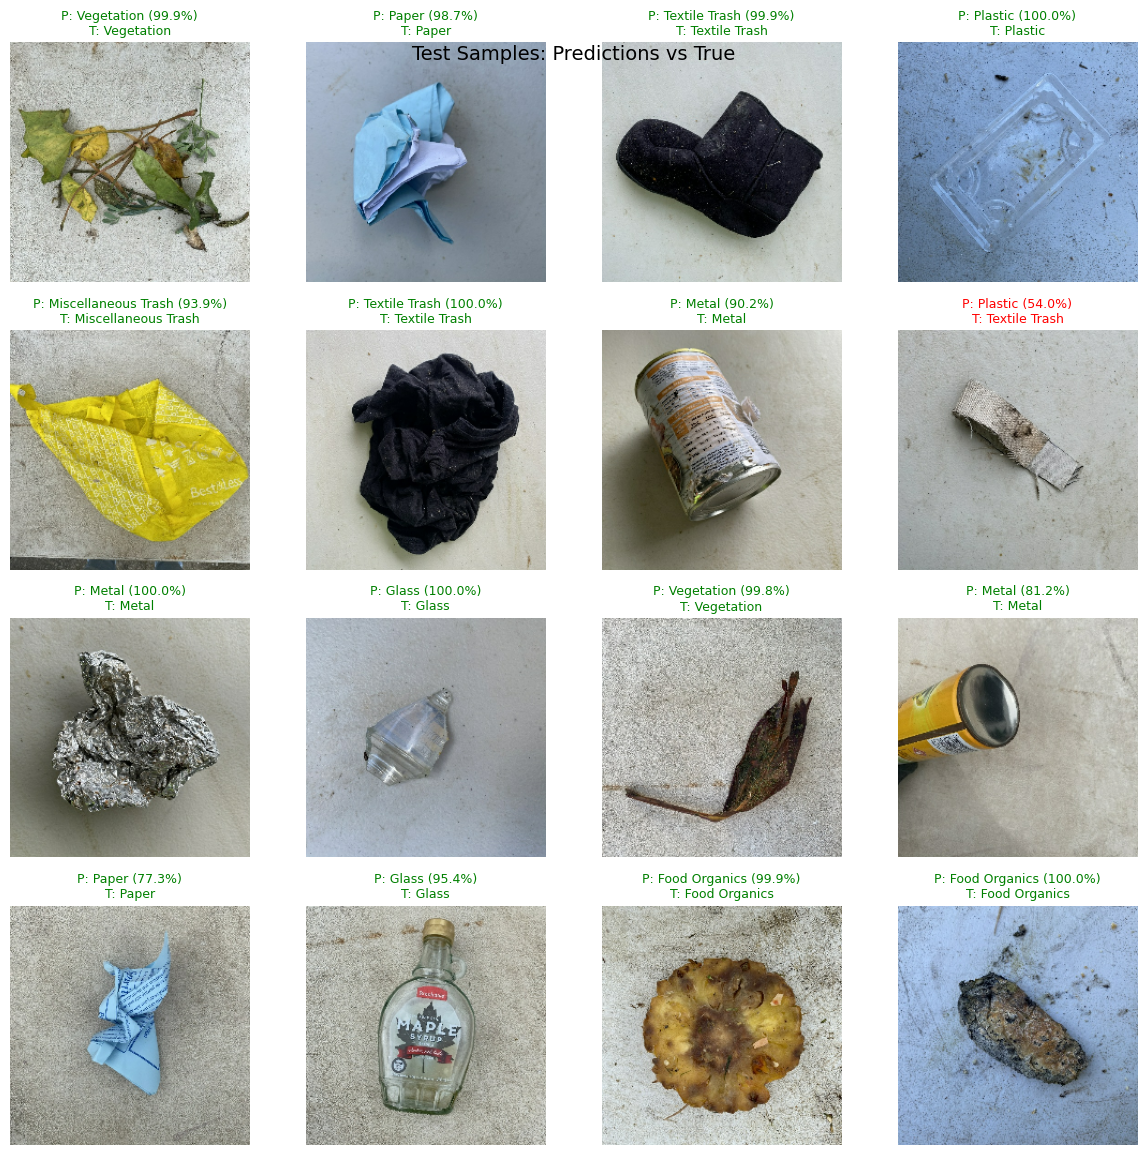

In [7]:
# =========================================================
#  Step 7.5: Show a grid of sample predictions from Test Set
# =========================================================
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

N = 16  # number of samples to show (4x4 grid)
samples = test_ds.unbatch().take(N)

imgs, trues, preds, confs = [], [], [], []

for img, lab in samples:
    img_np = img.numpy().astype("uint8")
    prob = model.predict(tf.expand_dims(img, 0), verbose=0)[0]
    pred_id = int(np.argmax(prob))
    conf = float(np.max(prob))

    imgs.append(img_np)
    trues.append(int(lab.numpy()))
    preds.append(pred_id)
    confs.append(conf)

# Create grid
rows, cols = 4, 4
plt.figure(figsize=(12, 12))
for i in range(N):
    plt.subplot(rows, cols, i + 1)
    plt.imshow(imgs[i])
    title = f"P: {class_names[preds[i]]} ({confs[i]*100:.1f}%)\nT: {class_names[trues[i]]}"
    color = 'green' if preds[i] == trues[i] else 'red'
    plt.title(title, color=color, fontsize=9)
    plt.axis('off')

plt.suptitle("Test Samples: Predictions vs True", fontsize=14, y=0.93)
plt.tight_layout()
plt.show()


In [8]:
from google.colab import files
files.download('/content/best_resnet50.keras')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

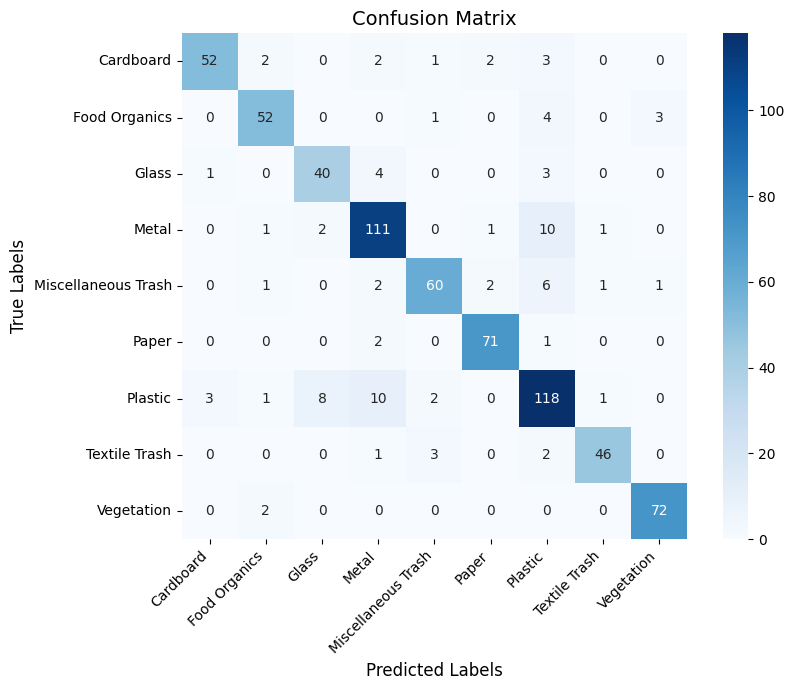

Classification Report:

                     precision    recall  f1-score   support

          Cardboard       0.93      0.84      0.88        62
      Food Organics       0.88      0.87      0.87        60
              Glass       0.80      0.83      0.82        48
              Metal       0.84      0.88      0.86       126
Miscellaneous Trash       0.90      0.82      0.86        73
              Paper       0.93      0.96      0.95        74
            Plastic       0.80      0.83      0.81       143
      Textile Trash       0.94      0.88      0.91        52
         Vegetation       0.95      0.97      0.96        74

           accuracy                           0.87       712
          macro avg       0.89      0.88      0.88       712
       weighted avg       0.88      0.87      0.87       712



In [12]:
# =========================================================
#  Step 8: Confusion Matrix + Classification Report
# =========================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Collect all true labels and predictions from the test set
y_true = []
y_pred = []

for images, labels in test_ds:
    # Get prediction probabilities for this batch
    probs = model.predict(images, verbose=0)
    preds = np.argmax(probs, axis=1)

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# ---- Pretty heatmap-style confusion matrix ----
plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=True,           # show numbers in cells
    fmt="d",              # integer format
    cmap="Blues",         # blue color map like the example
    xticklabels=class_names,
    yticklabels=class_names,
    square=True,
    cbar=True
)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted Labels", fontsize=12)
plt.ylabel("True Labels", fontsize=12)

plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# ---- Classification report (precision, recall, F1) ----
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
